In [48]:
import ephem

import pandas as pd

import datetime
from matplotlib import pyplot as plt
import plotly.graph_objects as go

from plotly.subplots import make_subplots
import matplotlib.pyplot as plt


input_file = "result_23Oct2020_fine_cw1500ps5_4mw.csv"

In [49]:
import numpy as np
import math
import mpmath
from scipy import special

def calculateDistance(T = np.linspace(-200,200,201), distMin = 500e3, maxElevation = 60):
    re = 6378
    radius = (re+distMin/1000)
    v= np.sqrt(398600/(6378+distMin/1000))*1000
    omega = v/radius*1e-3
  
    xOGS = 0
    yOGS = distMin/1000/np.tan(maxElevation/180*np.pi)
    zOGS = re

    xSat = radius*np.sin(omega*T)
    ySat = 0
    zSat = radius*np.cos(omega*T)
   
    dist = 1000*np.sqrt((xSat - xOGS)**2+(ySat - yOGS)**2+(zSat - zOGS)**2)
    xdist = 1000*(xSat-xOGS)
    ydist = 1000*(ySat-yOGS)
    zdist = 1000*(zSat-zOGS)
    
    elevationAngle = np.arctan((zSat - zOGS)/np.sqrt((xSat-xOGS)**2+((ySat-yOGS)**2)))
    azimuth = np.arctan((xSat-xOGS)/(ySat-yOGS))
   
    return dist, elevationAngle, v, T, xdist, ydist, zdist, azimuth
    
def BeamWidthReceiver(Distance, BeamWaist, Wavelength, MSquare, Jitter, TurbAngle):
    #Beam divergence including atmospheric and pointing effects
    w_0 = BeamWaist
    l = Wavelength
    M2 = MSquare
    d = Distance

    #Diffraction loss (Gaussian beam theory)
    z_R = np.pi*(w_0**2)/l;                                  #Rayleigh range
    w_d = M2*w_0*np.sqrt(1+np.square(d/z_R));                #Beam width at receiving telescope
    w_d = np.sqrt(w_d**2+(d*np.tan(Jitter))**2+(d*np.tan(TurbAngle))**2)
    return w_d

def ChannelLoss(Distance, WidthAtReceiver, ApertReceive, Elevation, AtmosAtten, PointingOffset = 0):
    
    if Distance.size > 1:
        Off = np.zeros((len(Distance)))
        w_d = np.zeros((len(Distance)))
        Ltr = np.zeros((len(Distance)))
        Losses = np.zeros((len(Distance)))
    
        for i in range(len(Distance)):
            #see https://arxiv.org/ftp/arxiv/papers/1605/1605.04241.pdf
            r = ApertReceive/2
            w_d[i] = WidthAtReceiver[i]
            d = Distance[i]
            e = Elevation[i]    
            Off[i] = np.tan(PointingOffset)*d
        
            Lgeom = np.exp(-2*(Off[i]**2)/(w_d[i]**2))*mpmath.nsum(lambda k:((2**k)*Off[i] **(2*k))/(w_d[i]**(2*k)*math.gamma(k+1)**2)*special.gammainc((float(k)+1), 2*(r**2)/(w_d[i]**2)),[0, np.inf])
            Lgeom = 10*np.log10(float(Lgeom)) 
            Ltr[i] = AtmosAtten*(1/np.cos((90-e)*np.pi/180))
        #    Ltr = -3
            Losses[i] = Lgeom + Ltr[i] 
    else:
        r = ApertReceive/2
        w_d = WidthAtReceiver
        d = Distance
        e = Elevation    
        Off = np.tan(PointingOffset)*d
    
        Lgeom = np.exp(-2*(Off**2)/(w_d**2))*mpmath.nsum(lambda k:((2**k)*Off **(2*k))/(w_d**(2*k)*math.gamma(k+1)**2)*special.gammainc((float(k)+1), 2*(r**2)/(w_d**2)),[0, np.inf])
        Lgeom = 10*np.log10(float(Lgeom)) 
        Ltr = AtmosAtten*(1/np.cos((90-e)*np.pi/180))
        #    Ltr = -3
        Losses = Lgeom + Ltr
    return Losses,w_d,Off,Ltr

######################### Qubesat parameters ##################################
ApertSat = 0.08
MSquare = 1.8
PointingJitter = 5e-6
CoeffWaist = 0.89
PointingOffset = 0
Waist = ApertSat/2*CoeffWaist

#Source parameters
Brightn = 56e6
IntrinsQBER = 0.01
CoincTimeSo = 1e-9
Wavel = 785e-9
DetEffSo = 0.25
DarkCSo = 15000
DeadTSo = 200e-9
DetJitter = 640e-12
Pap = 0.005

#Ground station parameters
ApertGr = 0.6
Backgr = 1.508e12
#Backgr = 0
AtmosAtten = -3
OpticEffGr = 0.5
FocalLenGr = 3.962
TurbAngle = 4e-6

#Quantum receiver parameters
DetEffRe = 0.25
DeadTRe = 27e-9
DarkCRe = 500
SensSizeRe = 500e-6
CoincTimeRe = 1e-9
SensSizeRe = 500e-6

#Protocol parameters
Type = "BBM92"
BasisRecon = 0.5
ErrCoEff = 1.1
CoincEff = 1
SizeTStamp = 64
CompRate = 1/4
beta = 1e-10/10
ecorr = 1e-10

#################################Single Pass###################################
#Scenario
'''
MaxElevation = 35
Altitude = 500e3

T = np.linspace(-300,300,1201)
a = calculateDistance(T,Altitude,MaxElevation)

Distance = a[0]
Elevation = a[1]*180/np.pi
Time = a[3]

b = BeamWidthReceiver(Distance,Waist,Wavel,MSquare,PointingJitter,TurbAngle)
WidthR = b
c = ChannelLoss(Distance,b,ApertGr,Elevation,AtmosAtten,PointingOffset)
#print (len(c))
Losses = c[0]
Ltr = c[3]
#print (len(Distance) )

TotalLossDown = Losses+10*np.log10(OpticEffGr)

#print (len(b))
'''

'\nMaxElevation = 35\nAltitude = 500e3\n\nT = np.linspace(-300,300,1201)\na = calculateDistance(T,Altitude,MaxElevation)\n\nDistance = a[0]\nElevation = a[1]*180/np.pi\nTime = a[3]\n\nb = BeamWidthReceiver(Distance,Waist,Wavel,MSquare,PointingJitter,TurbAngle)\nWidthR = b\nc = ChannelLoss(Distance,b,ApertGr,Elevation,AtmosAtten,PointingOffset)\n#print (len(c))\nLosses = c[0]\nLtr = c[3]\n#print (len(Distance) )\n\nTotalLossDown = Losses+10*np.log10(OpticEffGr)\n\n#print (len(b))\n'

In [50]:
def compute_TotalLoss(max_elev):
    MaxElevation = max_elev
    Altitude = 500e3

    T = np.linspace(-300,300,1201) #half second resolution
    a = calculateDistance(T,Altitude,MaxElevation)

    Distance = a[0]
    Elevation = a[1]*180/np.pi
    Time = a[3]

    b = BeamWidthReceiver(Distance,Waist,Wavel,MSquare,PointingJitter,TurbAngle)
    WidthR = b
    c = ChannelLoss(Distance,b,ApertGr,Elevation,AtmosAtten,PointingOffset)
    #print (len(c))
    Losses = c[0]
    Ltr = c[3]
    #print (len(Distance) )

    TotalLossDown = Losses+10*np.log10(OpticEffGr) -2

    return TotalLossDown,Distance,Elevation

In [51]:
#TotalLossDown = compute_TotalLoss(60)

In [52]:
def index_finder(val,Arr):
    st = 0
    et = len(Arr)-1
    for i in range(len(Arr)):
        if Arr[st]< val and Arr[i]>=val :
            st = i
            break
    #print (st, Arr[st-1],Arr[st])
    for i in range (st,len(Arr)):
        if Arr[i]<val:
            et = i
            break
    #print (et, Arr[et-1],Arr[et])
    return st, et
#st,et = index_finder(30,Elevation)

In [53]:
'''st,et = index_finder(30,Elevation)
df = pd.DataFrame()
df["elevation"] = Elevation[st:et]
df["distance"] = Distance[st:et]
df["lossDB"] = TotalLossDown[st:et]
transmissionFactorDown =  10**(TotalLossDown/10)
df["transmission_factor"] = transmissionFactorDown[st:et]'''

'st,et = index_finder(30,Elevation)\ndf = pd.DataFrame()\ndf["elevation"] = Elevation[st:et]\ndf["distance"] = Distance[st:et]\ndf["lossDB"] = TotalLossDown[st:et]\ntransmissionFactorDown =  10**(TotalLossDown/10)\ndf["transmission_factor"] = transmissionFactorDown[st:et]'

In [54]:
def compute_pass(max_elev):
    TotalLossDown,Distance,Elevation= compute_TotalLoss(max_elev)
    st,et = index_finder(30,Elevation)
    df = pd.DataFrame()
    df["elevation"] = Elevation[st:et]
    df["distance"] = Distance[st:et]
    df["lossDB"] = TotalLossDown[st:et]
    transmissionFactorDown =  10**(TotalLossDown/10)
    df["transmission_factor"] = transmissionFactorDown[st:et]
    df["lossDB_Round"] = round(df["lossDB"])
    return df

In [55]:
df = compute_pass(45)

df

,elevation,distance,lossDB,transmission_factor,lossDB_Round
0,30.108907,937505.311165,-40.903410,0.000081,-41.0
1,30.219198,935105.303270,-40.861382,0.000082,-41.0
2,30.329738,932713.462572,-40.819482,0.000083,-41.0
3,30.440525,930329.852797,-40.777709,0.000084,-41.0
4,30.551555,927954.538106,-40.736065,0.000084,-41.0
...,...,...,...,...,...
332,30.551555,927954.538106,-40.736065,0.000084,-41.0
333,30.440525,930329.852797,-40.777709,0.000084,-41.0
334,30.329738,932713.462572,-40.819482,0.000083,-41.0
335,30.219198,935105.303270,-40.861382,0.000082,-41.0


In [56]:
def pass_duration_test(max_elev):
    TotalLossDown,Distance,Elevation= compute_TotalLoss(max_elev)
    st,et = index_finder(30,Elevation)
    return (et-st)/2,max(TotalLossDown[st:et])
    

In [57]:
#or x in range (32,91):
#    print(x, pass_duration_test(x))

In [58]:
def get_data(loss,tdf):
    for index, row in tdf.iterrows():
        if int(abs(loss)) == int(row["loss"]):
            return round(row[" coincidence_count_rate"]),row[" QBER"],row[" sifted_key_length"]/row["duration(s)"]


In [59]:
def stitch(df,input_file):
    df_data = pd.read_csv(input_file)

    allloss = []
    for name in df_data["input_filename"]:
        allloss.append(name[5:7])
    df_data["loss"] = allloss

    ccr_list=[]
    qber_list = [] 
    skr_list = []
    for index, row in df.iterrows():
        ccr,qber,skr = get_data(row["lossDB_Round"],df_data)
        ccr_list.append(ccr)
        qber_list.append(qber)
        skr_list.append(skr)
    df["coincidences"] = ccr_list
    df["QBER"] = qber_list
    df["sifted_key_per_sec"] = skr_list 
    df["error_bits"] = df["sifted_key_per_sec"]*df["QBER"]
    Total_QBER = df["error_bits"].sum()/df["sifted_key_per_sec"].sum()
    Total_SiftedKey = round(df["sifted_key_per_sec"].sum())/2
    Total_coincidenceDetected = round(df["coincidences"].sum())/2
    pass_duration = len(df)/2
    return Total_QBER, Total_SiftedKey,Total_coincidenceDetected,pass_duration

In [60]:
def simulate_single_QKD_pass(max_elev,input_file):
    df = compute_pass(max_elev)
    #Total_QBER, Total_SiftedKey,Total_coincidenceDetected = stitch(df,input_file)
    return stitch(df,input_file)

In [61]:
lb = 31
le = 91
df_final = pd.DataFrame()
df_final ["max_eleve"] = list(range(lb,le))

elev_list = list(range(lb,le))
QBER_list = []
sfk_list = []
coin_list = []
pass_duration_list = []
for max_elev in range(lb,le):
    print (max_elev,', ',end='')
    Total_QBER, Total_SiftedKey,Total_coincidenceDetected,pass_duration = simulate_single_QKD_pass(max_elev,input_file)
    QBER_list.append(Total_QBER)
    sfk_list.append(Total_SiftedKey)
    coin_list.append(Total_coincidenceDetected)
    pass_duration_list.append(pass_duration)
    
    

31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 

In [62]:
ddf=pd.DataFrame()
ddf["max_elev"] = elev_list
ddf["QBER"] = QBER_list
ddf["sifted_key"] = sfk_list
ddf["total_coincidence"] = coin_list
ddf["pass_duration"] = pass_duration_list

In [63]:
ddf

,max_elev,QBER,sifted_key,total_coincidence,pass_duration
0,31,0.050973,3434.5,6842.5,57.5
1,32,0.050973,4688.5,9341.5,78.5
2,33,0.052774,5986.0,12019.0,94.5
3,34,0.053397,6890.5,13872.0,106.5
4,35,0.053695,7615.0,15351.0,116.5
5,36,0.054569,9048.5,18195.0,125.5
6,37,0.054862,9854.0,19806.0,132.5
7,38,0.055039,10570.0,21240.0,139.5
8,39,0.052142,11557.5,23214.0,144.5
9,40,0.051148,12331.5,24763.0,150.5


In [64]:
ddf.to_csv("elevation_sweep_extra_2dB.csv")

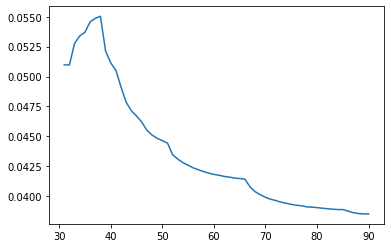

In [65]:
plt.plot(ddf["max_elev"],ddf["QBER"])

#plt.plot([1, 2, 3, 4], [10, 20, 25, 30], color='lightblue', linewidth=3)
#plt.scatter([0.3, 3.8, 1.2, 2.5], [11, 25, 9, 26], color='darkgreen', marker='^')
#plt.xlim(0.5, 4.5)
plt.show()

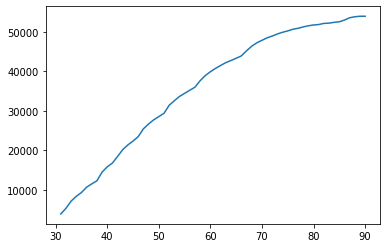

In [47]:
plt.plot(ddf["max_elev"],ddf["sifted_key"])


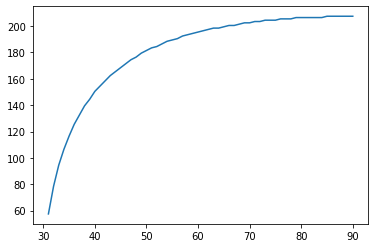

In [41]:
plt.plot(ddf["max_elev"],ddf["pass_duration"])